In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil

## Preparing Dataset

### Check any corrupted images (0 bytes sized)

In [2]:
data_path="./tomato_dataset_raw/"

tomato_early_blight=[]
tomato_late_blight=[]
tomato_healthy=[]

labels=3
total_raw_data=np.zeros((labels), dtype=int)
total_checked_data=np.zeros((labels), dtype=int)

for i, d in enumerate(sorted(os.listdir(data_path))):
    for f in os.listdir(os.path.join(data_path, d)):
        total_raw_data[i] += 1
        f=os.path.join(data_path, d, f)
        fsize=os.path.getsize(f)
        if fsize > 0:
            total_checked_data[i] += 1
            if i == 0:
                tomato_early_blight.append(f)
            if i == 1:
                tomato_late_blight.append(f)
            if i == 2:
                tomato_healthy.append(f)
        else:
            print(f"Removing file {f} has 0 bytes size")
    print(f"\nSelected {total_checked_data[i]} images from dir {d} with total of {total_raw_data[i]}")

Removing file ./tomato_dataset_raw/Tomato_Early_blight/unnamed_.jpg has 0 bytes size
Removing file ./tomato_dataset_raw/Tomato_Early_blight/unnamed.jpg has 0 bytes size
Removing file ./tomato_dataset_raw/Tomato_Early_blight/unnamed__.jpg has 0 bytes size

Selected 1000 images from dir Tomato_Early_blight with total of 1003

Selected 1909 images from dir Tomato_Late_blight with total of 1909

Selected 1591 images from dir Tomato_healthy with total of 1591


### Store into new dir

In [3]:
fixed_data_path="./data/"

if os.path.exists(fixed_data_path):
    shutil.rmtree(fixed_data_path)
    
list_dir = [tomato_early_blight, tomato_late_blight, tomato_healthy]
    
for i,d in enumerate(["tomato_early_blight", "tomato_late_blight", "tomato_healthy"]):
    os.makedirs(os.path.join(fixed_data_path, d))
    for srcdir in list_dir[i]:
        shutil.copyfile(srcdir, os.path.join(fixed_data_path, d, srcdir.split("/")[-1]))
    print(f"Directory {d} has been successfully created")

Directory tomato_early_blight has been successfully created
Directory tomato_late_blight has been successfully created
Directory tomato_healthy has been successfully created


## Image Processing

In [6]:
IMG_SIZE=256
BATCH_SIZE=24

data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=fixed_data_path,
    shuffle=True,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

classes=data.class_names
print("Class names:",classes)
print("Length of the data within each class:",len(data))
len(data)*BATCH_SIZE

Found 4500 files belonging to 3 classes.
Class names: ['tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']
Length of the data within each class: 188


4512

### Visualization

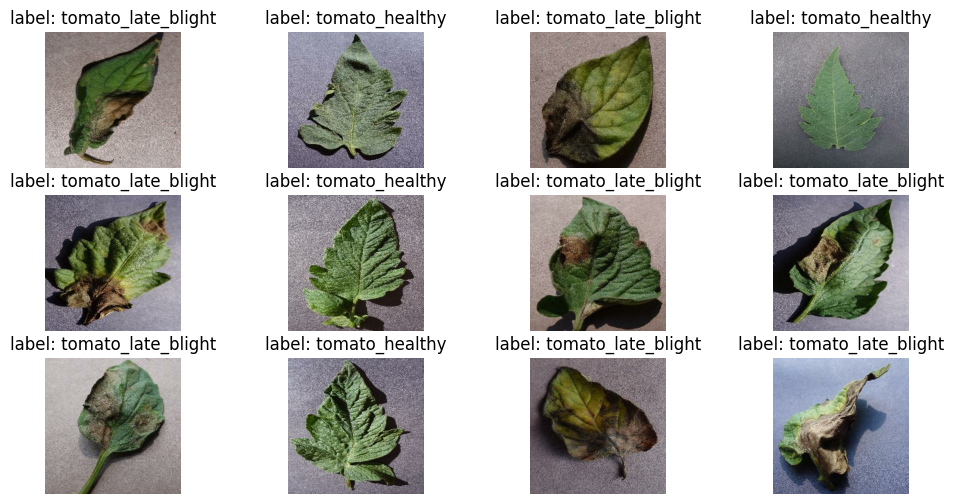

In [7]:
plt.figure(figsize=(12, 6))
for img_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.title(f"label: {classes[label_batch[i]]}")
        plt.axis("Off")
        plt.imshow(img_batch[i].numpy().astype("int"));

### Splitting the Data into Train, Val, and Test

In [8]:
len_data=len(data)

# Shuffle data
data=data.shuffle(buffer_size=10000, seed=42)

train_size=int(len_data*0.75)
val_size=int(len_data*0.15)

train_data=data.take(train_size)
val_data=data.skip(train_size).take(val_size)
test_data=data.skip(train_size).skip(val_size)

print(f"""Length of data in each batch
ori data: {len_data}
train data: {len(train_data)}
val data: {len(val_data)}
test data: {len(test_data)}
""")

Length of data in each batch
ori data: 188
train data: 141
val data: 28
test data: 19



### Augmenting Data

In [9]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0),
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(.1),
])

## Creating Model

### model 1

In [10]:
tf.config.list_logical_devices(), tf.config.list_physical_devices()

([LogicalDevice(name='/device:CPU:0', device_type='CPU'),
  LogicalDevice(name='/device:GPU:0', device_type='GPU')],
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [11]:
IMG_SHAPE=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)

model_1 = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax"),
], name="model_1")

model_1.build(input_shape=IMG_SHAPE)
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (24, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (24, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (24, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (24, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (24, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (24, 62, 62, 64)         0         
 2D)                                                       

In [12]:
model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [13]:
history_1 = model_1.fit(
    train_data,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data,
)

Epoch 1/30


2024-04-19 22:17:56.358086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


141/141 [==============================] - 21s 97ms/step - loss: 0.9639 - accuracy: 0.5451 - val_loss: 1.2686 - val_accuracy: 0.4717
Epoch 2/30
141/141 [==============================] - 13s 85ms/step - loss: 0.7827 - accuracy: 0.6868 - val_loss: 0.6795 - val_accuracy: 0.6920
Epoch 3/30
141/141 [==============================] - 13s 86ms/step - loss: 0.6511 - accuracy: 0.7358 - val_loss: 0.7385 - val_accuracy: 0.7182
Epoch 4/30
141/141 [==============================] - 13s 86ms/step - loss: 0.5612 - accuracy: 0.7794 - val_loss: 0.6288 - val_accuracy: 0.7470
Epoch 5/30
141/141 [==============================] - 13s 86ms/step - loss: 0.4926 - accuracy: 0.7972 - val_loss: 0.4190 - val_accuracy: 0.8423
Epoch 6/30
141/141 [==============================] - 13s 86ms/step - loss: 0.4288 - accuracy: 0.8280 - val_loss: 0.6709 - val_accuracy: 0.7366
Epoch 7/30
141/141 [==============================] - 13s 87ms/step - loss: 0.4314 - accuracy: 0.8366 - val_loss: 0.2741 - val_accuracy: 0.8735
Epo

### Model 2

In [14]:
model_2 = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=IMG_SHAPE),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax"),
], name="model_2")

model_2.build(input_shape=IMG_SHAPE)
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (24, 254, 254, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (24, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (24, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (24, 62, 62, 32)         0         
 2D)                                                       

In [15]:
model_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [16]:
history_2 = model_2.fit(
    train_data,
    epochs=30,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data,
)

Epoch 1/30
141/141 [==============================] - 18s 98ms/step - loss: 0.9975 - accuracy: 0.4650 - val_loss: 0.7509 - val_accuracy: 0.5982
Epoch 2/30
141/141 [==============================] - 12s 75ms/step - loss: 0.7855 - accuracy: 0.6379 - val_loss: 0.5839 - val_accuracy: 0.7277
Epoch 3/30
141/141 [==============================] - 11s 75ms/step - loss: 0.5803 - accuracy: 0.7530 - val_loss: 0.3668 - val_accuracy: 0.8482
Epoch 4/30
141/141 [==============================] - 11s 71ms/step - loss: 0.4547 - accuracy: 0.8090 - val_loss: 0.5667 - val_accuracy: 0.7946
Epoch 5/30
141/141 [==============================] - 11s 71ms/step - loss: 0.4191 - accuracy: 0.8277 - val_loss: 0.4702 - val_accuracy: 0.8170
Epoch 6/30
141/141 [==============================] - 11s 71ms/step - loss: 0.3584 - accuracy: 0.8579 - val_loss: 0.2736 - val_accuracy: 0.8869
Epoch 7/30
141/141 [==============================] - 11s 70ms/step - loss: 0.3422 - accuracy: 0.8680 - val_loss: 0.3523 - val_accuracy:

## Plot History

### History 1

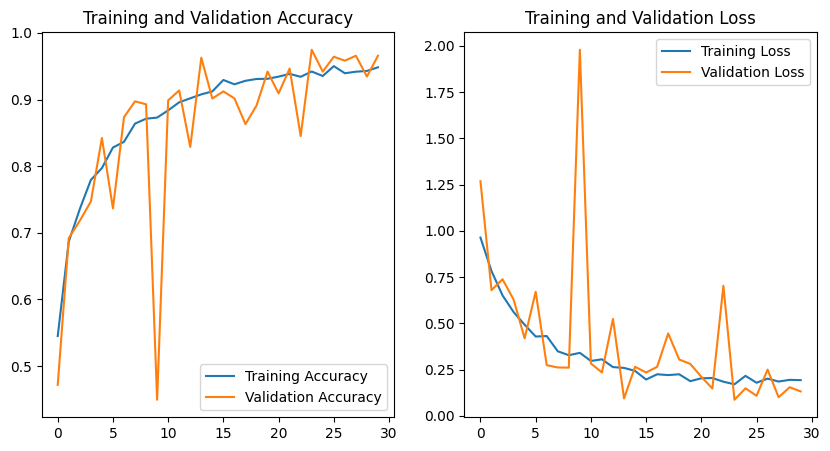

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history_1.history["accuracy"], label="Training Accuracy")
plt.plot(history_1.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(history_1.history["loss"], label="Training Loss")
plt.plot(history_1.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

### History 2

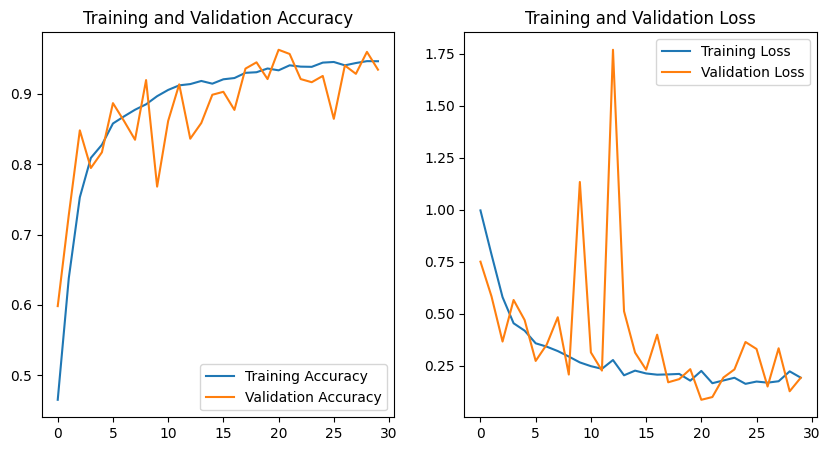

In [22]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history_2.history["accuracy"], label="Training Accuracy")
plt.plot(history_2.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(history_2.history["loss"], label="Training Loss")
plt.plot(history_2.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

In [23]:
import pickle

with open("history_model1.pkl", "wb") as f:
    pickle.dump(history_1.history, f)